In [1]:
import numpy as np
%load_ext autoreload
%autoreload 2
import torch
from numpy.random import uniform
from torch_geometric.loader import DataLoader
from gnn_tracking.preprocessing.point_cloud_builder import PointCloudBuilder
from gnn_tracking.utils.plotting import GraphPlotter
from gnn_tracking.utils.plotting import PointCloudPlotter
from gnn_tracking.models.track_condensation_networks import PointCloudTCN, GraphTCN
from pathlib import Path


In [2]:
from gnn_tracking.utils.plotting import EventPlotter

# we'll use n_evts * n_sectors = 640 graphs
n_evts, n_sectors = 10, 64
indir='/tigress/jdezoort/codalab/train_1'
# indir='/home/kl5675/Documents/22/git_sync/gnn_tracking/src/gnn_tracking/test_data'
# event_plotter = EventPlotter(indir=indir)
# event_plotter.plot_ep_rv_uv(evtid=21289)

In [3]:

# build point clouds for each sector in the pixel layers only
# pc_builder = PointCloudBuilder(indir=indir, outdir=str(Path("~/data/gnn_tracking/point_clouds").expanduser()),
#                                n_sectors=n_sectors, pixel_only=True, redo=False, measurement_mode=False, thld=0.9)
# pc_builder.process(n=10, verbose=False)

Processing /tigress/jdezoort/codalab/train_1/event000021289
Processing /tigress/jdezoort/codalab/train_1/event000021054
Processing /tigress/jdezoort/codalab/train_1/event000021371
Processing /tigress/jdezoort/codalab/train_1/event000021460
Processing /tigress/jdezoort/codalab/train_1/event000021612
Processing /tigress/jdezoort/codalab/train_1/event000021949
Processing /tigress/jdezoort/codalab/train_1/event000021853
Processing /tigress/jdezoort/codalab/train_1/event000021164
Processing /tigress/jdezoort/codalab/train_1/event000021475
Processing /tigress/jdezoort/codalab/train_1/event000021135


In [4]:
# each point cloud is a PyG Data object 
# point_cloud = pc_builder.data_list[0]
# good = ((point_cloud.sector>-1) & (point_cloud.particle_id>0) &
#         (point_cloud.pt > 0.5))


In [5]:
# point_cloud

Data(x=[1326, 6], layer=[1326], particle_id=[1326], pt=[1326], reconstructable=[1326], sector=[1326])

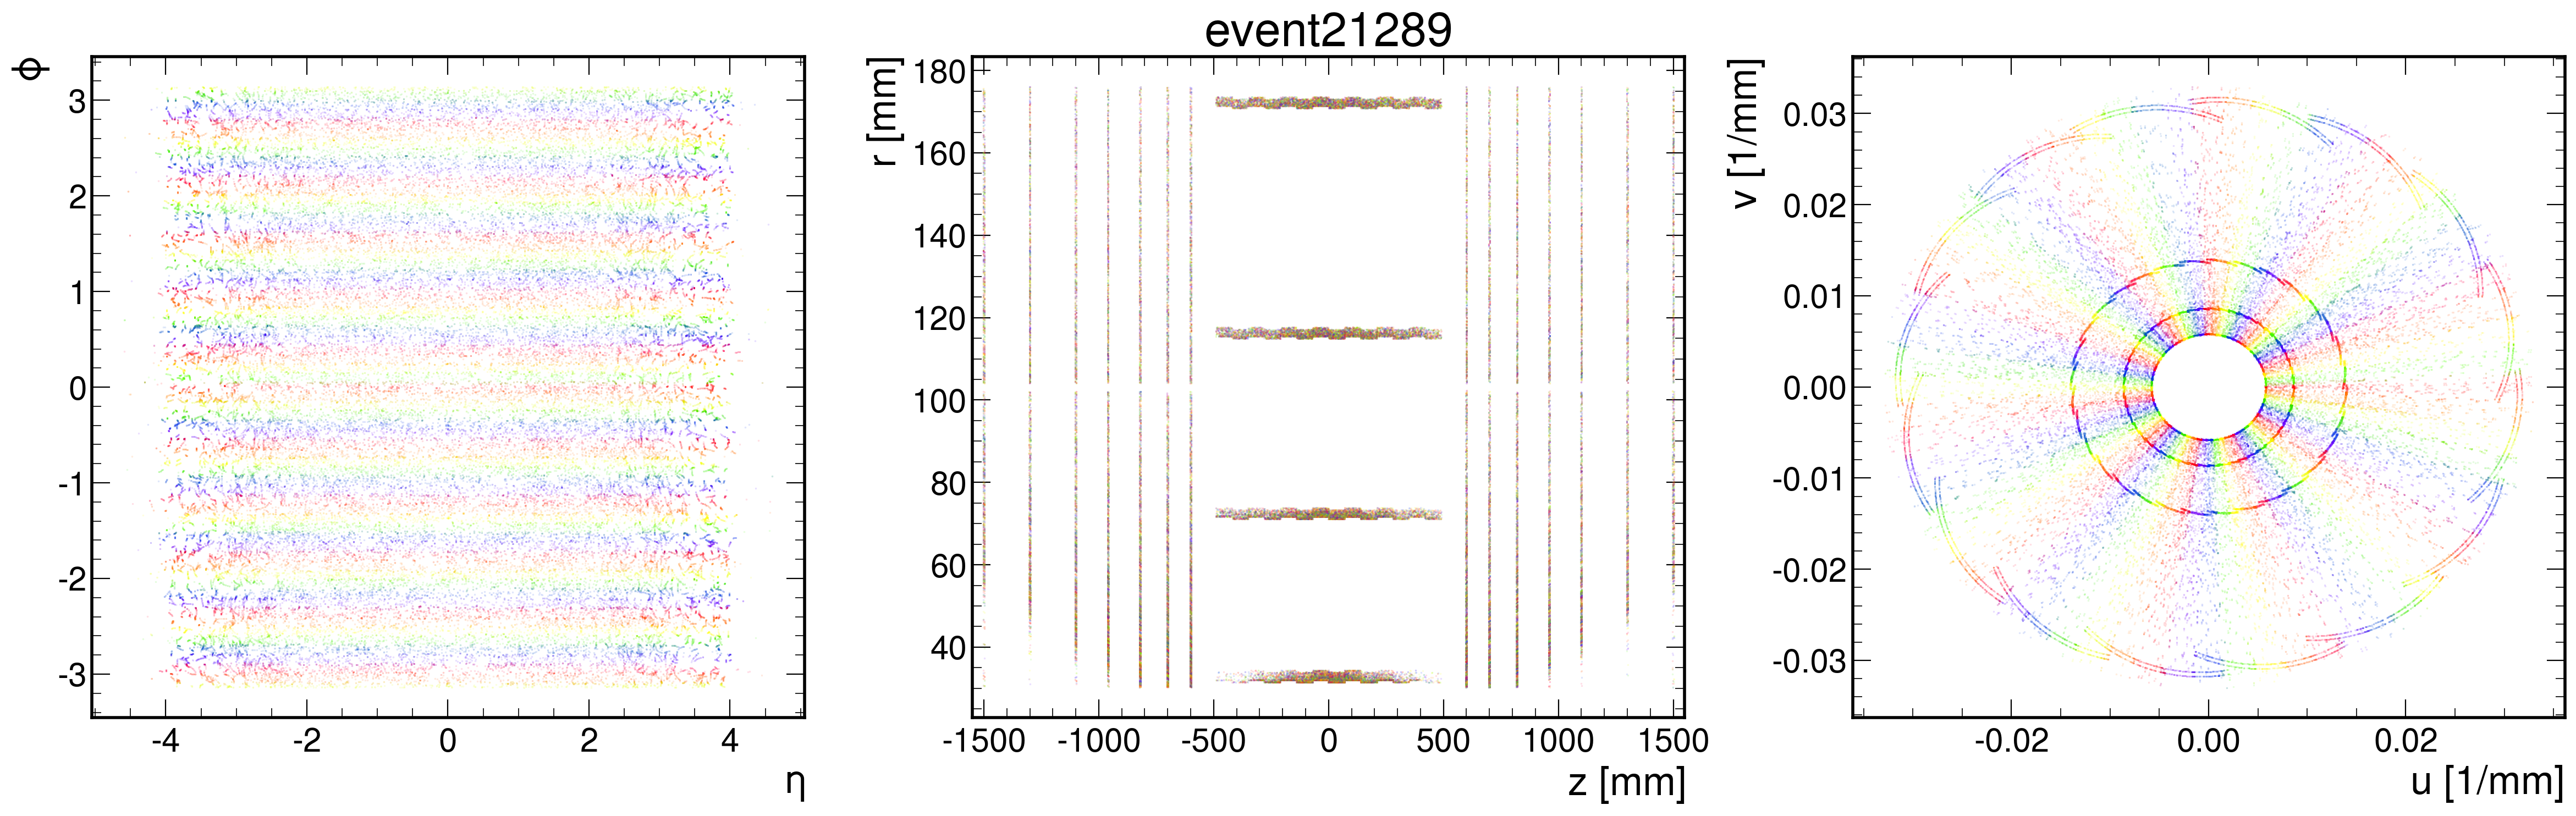

In [6]:


# visualize the secto
# rs in each event and an overlapped ('extended') sector
# pc_plotter = PointCloudPlotter(str(Path("~/data/gnn_tracking/point_clouds").expanduser()),
#                                n_sectors=pc_builder.n_sectors)
# pc_plotter.plot_ep_rv_uv_all_sectors(21289)
# pc_plotter.plot_ep_rv_uv_with_boundary(21289, 18,
#                                        pc_builder.sector_di,
#                                        pc_builder.sector_ds)

In [7]:
! mkdir /home/kl5675/data/gnn_tracking/graphs

mkdir: cannot create directory '/home/kl5675/data/gnn_tracking/graphs': File exists


In [3]:
# we can build graphs on the point clouds using geometric cuts

from gnn_tracking.graph_construction.graph_builder import GraphBuilder
graph_builder = GraphBuilder(str(Path("~/data/gnn_tracking/point_clouds").expanduser()), str(Path("~/data/gnn_tracking/graphs").expanduser()), redo=False)
graph_builder.process(verbose=True, n=None)

In [9]:
! ls  /home/kl5675/data/gnn_tracking/

graphs	point_clouds


In [10]:


# the graph plotter shows the true and false edges constructed by the builder

# graph_plotter = GraphPlotter()
# graph = graph_builder.data_list[0]
# print(graph)
# evtid, s = graph.evtid.item(), graph.s.item()

# takes a minute to run, but cool visual!
#graph_plotter.plot_rz(graph_builder.data_list[0], 
#          f'event{evtid}_s{s}')

Data(x=[1326, 6], edge_index=[2, 55058], edge_attr=[55058, 4], y=[55058], pt=[1326], particle_id=[1326], reconstructable=[1326], sector=[1326], evtid=[1], s=[1])


In [4]:
from gnn_tracking.training.graph_tcn_trainer import GraphTCNTrainer

# use cuda (gpu) if possible, otherwise fallback to cpu
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(f'Utilizing {device}')

# use reference graph to get relevant dimensions 
g = graph_builder.data_list[0]
node_indim = g.x.shape[1]
edge_indim = g.edge_attr.shape[1]
hc_outdim = 2 # output dim of latent space  

# partition graphs into train, test, val splits
graphs = graph_builder.data_list
n_graphs = len(graphs)
rand_array = uniform(low=0, high=1, size=n_graphs)
train_graphs = [g for i, g in enumerate(graphs) if (rand_array<=0.7)[i]]
test_graphs = [g for i, g in enumerate(graphs) if ((rand_array>0.7) & (rand_array<=0.9))[i]]
val_graphs = [g for i, g in enumerate(graphs) if (rand_array>0.9)[i]]

# build graph loaders
params = {'batch_size': 1, 'shuffle': True, 'num_workers': 1}

Utilizing cpu


In [5]:
torch.cuda.is_available()

False

In [6]:
train_loader = DataLoader(list(train_graphs), **params)

In [7]:

params = {'batch_size': 1, 'shuffle': False, 'num_workers': 2}
test_loader = DataLoader(list(test_graphs), **params)
val_loader = DataLoader(list(val_graphs), **params)
loaders = {'train': train_loader, 'test': test_loader,
           'val': val_loader}
print('Loader sizes:', [(k, len(v)) for k, v in loaders.items()])

# set up a model and trainer


Loader sizes: [('train', 449), ('test', 129), ('val', 62)]


In [11]:
torch.manual_seed(0)
import numpy as np
np.random.seed(0)
import random
random.seed(0)

In [12]:

# from gnn_tracking.utils.early_stopping import StopEarly
model = GraphTCN(node_indim, edge_indim, hc_outdim, hidden_dim=64)

trainer = GraphTCNTrainer(model=model, loaders=loaders, )

In [13]:
import warnings
warnings.filterwarnings('ignore')
trainer.train(epochs=2, max_batches=1)

---- Epoch 1 ----
Epoch 1 (0/449): loss=262.16983; loss_W=0.62345; loss_V=260.54913; loss_B=0.99726;
test {'total': 190.57991549210956, 'W': 0.6083411084589108, 'V': 188.96493293703065, 'B': 1.0066414466199949, 'acc': 0.22173364381986144}
---- Epoch 2 ----
Epoch 2 (0/449): loss=233.73207; loss_W=0.60673; loss_V=232.13496; loss_B=0.99037;
test {'total': 125.97275188311126, 'W': 0.5980548211770464, 'V': 124.35823085696198, 'B': 1.0164662049722302, 'acc': 0.22686775915109259}


---- Epoch 1 ----
Epoch 1 (0/455): loss=260.12961; loss_W=0.68929; loss_V=258.44443; loss_B=0.99589;
test {'total': 189.82893915367126, 'W': 0.6879563589096069, 'V': 188.13434088134767, 'B': 1.0066419134140014, 'acc': 0.3993645237849131}
---- Epoch 2 ----
Epoch 2 (0/455): loss=199.62143; loss_W=0.68856; loss_V=197.93004; loss_B=1.00283;
test {'total': 118.73843816375732, 'W': 0.6872770781517029, 'V': 117.03249960327149, 'B': 1.018661482334137, 'acc': 0.06346894882998515}